# 개요

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- 전이학습
  - 기존신경망에 새로운 신경망을 연결
  - 기존신경망의 마지막 층을 제외하고 새로운 신경망에 연결
    - 직접 붙일수도 있고, 별도의 신경망으로 연계
  - 이미지 부풀리기 적용
    - 훈련용 데이터만 적용
    - 테스트용 데이터는 미적용

- 데이터
  - 치매/일반인 뇌 분류 사진
    - 의학용 데이터는 소량만 제공
  - 총개수 280
    - 훈련용 : 160
      - 이미지 부플리기 -> ImageDataGenerator
    - 테스트용 : 120


# 모듈가져오기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

# 데이터 공급자 생성

In [ ]:
# 제너레이터 생성
train_datagen = ImageDataGenerator( 
  rescale            = 1./255  # 0~255 RGB를 0~1 RGB로 정규화
  ,horizontal_flip   = True    # 수평 대칭 이미지를 50% 확률로 생성
  #,vertical_flip     = True   # 수직 대칭 이미지를 50% 확률로 생성
  ,width_shift_range = 0.1     # 전체 크기의 10% 범위에서 좌우 이동
  ,height_shift_range= 0.1     # 전체 크기의 10% 범위에서 상하 이동
  #,rotation_range    = 10     # 10도만큼 회전  
  #,shear_range       = 0.5    # 좌표를 하나 고정해서 나머지를 주어진 수치만큼 이동 
  #,zoom_range        = 1.4    # 기존 크기에 1.4배 확대
  #,fill_mode         = 'nearest' # 빈공간을 채우는 기법, 
                               # nearest : 가장 비슷한 색상으로 채운다
)

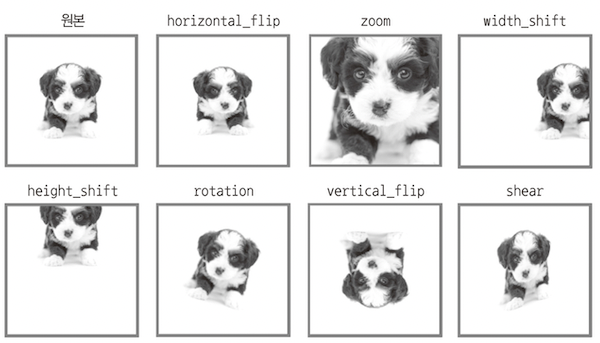

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/new_res/이미지데이터제러네리터.png')

In [ ]:
# 테스트용 데이터 생성/공급자 -> 원본 그대로 사용
test_datagen = ImageDataGenerator( rescale=1./255 )

In [ ]:
# 이미지 데이터의 크기가 (150,150)
# 배치 사이즈를 5로 설정 => 훈련횟수를 증가시키고, 중복 데이터가
# 1회 학습시 제공되는 확률을 낮췄다
# 제너레이터를 통해서 훈련시 데이터를 공급하는 공급자 생성
# 훈련용
train_generator = train_datagen.flow_from_directory(
  '/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/data-ch20/train'
  ,target_size=(150, 150)
  ,batch_size=5
  ,class_mode='binary'
)

# 테스트용
test_generator  = test_datagen.flow_from_directory(
  '/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/data-ch20/test'    
  ,target_size=(150, 150)
  ,batch_size=5
  ,class_mode='binary'
)

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# 새로운 신경망 생성 - CNN

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3),input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [ ]:
from tensorflow.python.module.module import valid_identifier
from tensorflow.python.ops.variables import VariableAggregation
# 모델 실행 옵션 설계
# 최적화 도구에 커스터마이즈  => 직접 생성해서 지정, 'adam':기본값
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002),              
              metrics=['accuracy'] )
# 조기학습종료
early_stopping_cb = EarlyStopping(patience=5) 

# 학습
import tensorflow as tf
with tf.device('/device:GPU:0'):
  # 데이터 공급자에서 데이터가 존재하는 폴더로 정답이 구분된다
  hist = model.fit(
      train_generator,
      epochs=100,
      validation_data=test_generator,
      validation_steps=10,
      callbacks=[ early_stopping_cb ]
  )
# 최초 학습은 비교적 긴 시간이였으나, 최적화가가 이루어지고 나서
# 점점 학습속도가 기하급수적으로 빨라졌다
# 48% -> 96% 학습 완료, 33세대학습 완료

Epoch 1/100
32/32 [==============================] - 70s 2s/step - loss: 0.6938 - accuracy: 0.4938 - val_loss: 0.6864 - val_accuracy: 0.6600
Epoch 2/100
32/32 [==============================] - 14s 451ms/step - loss: 0.6746 - accuracy: 0.5500 - val_loss: 0.6689 - val_accuracy: 0.8400
Epoch 3/100
32/32 [==============================] - 11s 358ms/step - loss: 0.6723 - accuracy: 0.6062 - val_loss: 0.6644 - val_accuracy: 0.6600
Epoch 4/100
32/32 [==============================] - 10s 303ms/step - loss: 0.6739 - accuracy: 0.6125 - val_loss: 0.6643 - val_accuracy: 0.5400
Epoch 5/100
32/32 [==============================] - 7s 229ms/step - loss: 0.6583 - accuracy: 0.5625 - val_loss: 0.7049 - val_accuracy: 0.4400
Epoch 6/100
32/32 [==============================] - 6s 202ms/step - loss: 0.6146 - accuracy: 0.7000 - val_loss: 0.5776 - val_accuracy: 0.7200
Epoch 7/100
32/32 [==============================] - 6s 200ms/step - loss: 0.5776 - accuracy: 0.7125 - val_loss: 0.6921 - val_accuracy: 0.540

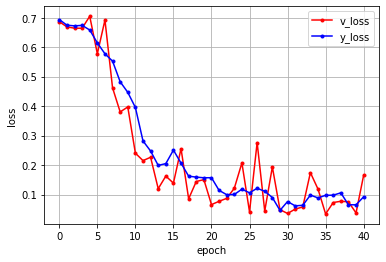

In [ ]:
def showLoss( hist ):
  # 모니터닝 결과 시각화
  v_loss = hist.history['val_loss']
  y_loss = hist.history['loss']
  x = np.arange( len(y_loss) )

  plt.plot( x, v_loss, marker='.', c='red' , label='v_loss')
  plt.plot( x, y_loss, marker='.', c='blue', label='y_loss')

  plt.legend()
  plt.grid()
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

showLoss( hist )

- 소량의 데이터로 만족할만한 성과가 나왔다 -> 이 결과를 인정받기에는 데이터가 너무 적다
- 소량의 데이터로 학습한 모델의 성능을 높이기 위해, 대량의 데이터로 오랜시간 학습한 모델을 가져와서(전이학습) 기존의 모델에 연결하여, 보다 성능을 높이겠다

# 전이학습으로 기존 모델의 성능을 극대화

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

# 위쪽 코드 대비 추가
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

- 케라스에서 제공하는 기존모델
  - https://keras.io/applications

## 데이터 공급자

In [ ]:
train_datagen = ImageDataGenerator( 
  rescale            = 1./255
  ,horizontal_flip   = True  
  ,width_shift_range = 0.1
  ,height_shift_range= 0.1  
)
test_datagen = ImageDataGenerator( rescale=1./255 )

In [ ]:
train_generator = train_datagen.flow_from_directory(
  '/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/data-ch20/train'
  ,target_size=(150, 150)
  ,batch_size=5
  ,class_mode='binary'
)

# 테스트용
test_generator  = test_datagen.flow_from_directory(
  '/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/data-ch20/train'    
  ,target_size=(150, 150)
  ,batch_size=5
  ,class_mode='binary'
)

Found 160 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


- CNN 모델의 앞쪽은 대규모 데이터셋으로 학습된 기존 네트워크 사용
  - pre-trained 네트워크
- CNN 모델의 뒤쪽은 새로 만든 신경망 사용
- 조건 : 소규모 데이터를 가지고 학습을 진행할때
- 2개 모델이 잘 연계되도록 => 파인튜닝 진행

## 전이학습 모델 로드

In [ ]:
# include_top=False : 마지막층, 분류를 담당하는 층을 사용할것인가?
# weights='imagenet': 사용하고자 하는 VGG16 모델은 
#                     이미지네트워크로 학습된 모델이다
#                     pre-trained on ImageNet
transfer_model = VGG16(include_top=False, weights='imagenet', 
                      input_shape=(150,150,3))

transfer_model.trainable = False # 이미 학습된 가중치 그대로 사용
transfer_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

## 파인튜닝할 모델 생성

In [ ]:
ft_model = models.Sequential()

# VGG을 이어서 붙였다
ft_model.add( transfer_model )

ft_model.add( Flatten() )
ft_model.add( Dense(64) )
ft_model.add( Activation('relu') )
ft_model.add( Dropout(0.5) )

ft_model.add( Dense(1) )
ft_model.add( Activation('sigmoid') )

ft_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                524352    
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
 activation_6 (Activation)   (None, 1)                

In [ ]:
ft_model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002),              
              metrics=['accuracy'] )
early_stopping_cb = EarlyStopping(patience=5) 

with tf.device('/device:GPU:0'):
  hist = model.fit(
      train_generator,
      epochs=50, #세대 학습값을 줄임(위의 상황고려하여)
      validation_data=test_generator,
      validation_steps=10,
      callbacks=[ early_stopping_cb ]
  )

Epoch 1/50
32/32 [==============================] - 6s 181ms/step - loss: 0.0710 - accuracy: 0.9750 - val_loss: 0.0236 - val_accuracy: 1.0000
Epoch 2/50
32/32 [==============================] - 6s 179ms/step - loss: 0.0732 - accuracy: 0.9563 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 3/50
32/32 [==============================] - 6s 177ms/step - loss: 0.0582 - accuracy: 0.9875 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 4/50
32/32 [==============================] - 6s 178ms/step - loss: 0.0754 - accuracy: 0.9875 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 5/50
32/32 [==============================] - 6s 177ms/step - loss: 0.1176 - accuracy: 0.9625 - val_loss: 0.0461 - val_accuracy: 0.9800
Epoch 6/50
32/32 [==============================] - 6s 177ms/step - loss: 0.1297 - accuracy: 0.9500 - val_loss: 0.0725 - val_accuracy: 0.9600
Epoch 7/50
32/32 [==============================] - 6s 177ms/step - loss: 0.0914 - accuracy: 0.9688 - val_loss: 0.1220 - val_accuracy: 0.9600
Epoch 

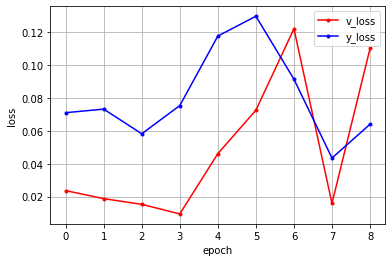

In [ ]:
showLoss( hist )
# 이미 손실값은 0에 급접해서 진행
# y값의 리미트를 넣어서 상위 그래프와 비교하면 더욱 좋을듯

# 전이학습 모델로 예측한 데이터를 2차 데이터로 사용해서 학습

- 참고: 스태킹기법 연상

## hub를 통해서 모델 획득

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

# 위쪽 코드 대비 추가
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

# https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/5",
                   output_shape=[2048],
                   trainable=False),  # Can be True, see below.
    #tf.keras.layers.Dense(num_classes, activation='softmax')
])
# 이 모델은 299,299,3 채널 이미지를 입력으로 사용
m.build([None, 299, 299, 3])  # Batch input shape.

image_size = 299
batch_size = 32

In [ ]:
m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


## 데이터 공급자

In [ ]:
train_datagen = ImageDataGenerator(
  rescale            = 1./255
  ,horizontal_flip   = True
  #,vertical_flip     = True
  ,width_shift_range = 0.1
  ,height_shift_range= 0.1
  #,rotation_range    = 10
  ,shear_range       = 0.1
  ,zoom_range        = 0.1
  #,fill_mode         = 'nearest'
  ,validation_split  = 0.25
)
# 데이터 부풀리기 하지 않음
vaild_datagen = ImageDataGenerator( rescale=1./255
                                   ,validation_split  = 0.25  )

In [ ]:
# 공급자에서 이미지 크기를 사전학습된 모델의 input에 맞춰 확대
train_generator = train_datagen.flow_from_directory(
  '/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/data-ch20/train'
  ,target_size= (image_size, image_size) # 299로 교체->리사이징해줌
  ,batch_size = batch_size # 학습 회수는 줄어들것이다
  ,class_mode = 'binary'
  ,seed       = 30
  ,shuffle    = True
  ,subset     = 'training'
)
valid_generator  = vaild_datagen.flow_from_directory(
  '/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/data-ch20/test'    
  ,target_size=(image_size, image_size)
  ,batch_size =batch_size
  ,class_mode ='binary'
  ,seed       = 30
  ,shuffle    = True
  ,subset     = 'validation'
)

Found 120 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


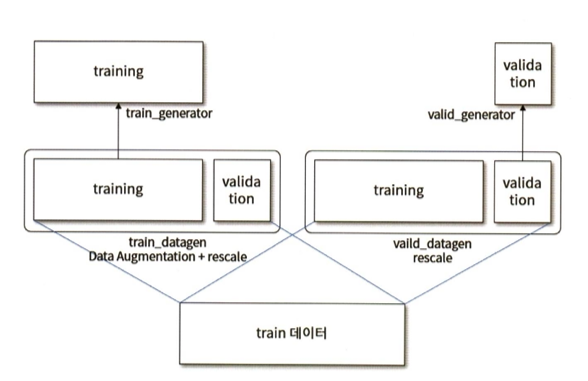

In [ ]:
Image('/content/drive/MyDrive/ComputerProgramming/DeepLearning/2.딥러닝/res/new_res/전이학습-이미지부풀리기.png')
# 아래 그림과는 달리 Vaildation 데이터는 test쪽에서 공급

In [ ]:
# train_X, train_Y 데이터 준비
step    = (160*2) // batch_size
train_X = []
train_Y = []

for _ in range( step ):
  # 훈련데이터에서 데이터 램덤 추출 (배치사이즈 32개)
  x, y = train_generator.next()
  y_   = m.predict( x )

  # 이 데이터가 새로운 신경망의 데이터가 된다
  train_X.extend( y_ )
  train_Y.extend( y  )

train_X = np.array( train_X )
train_Y = np.array( train_Y )

train_X.shape, train_Y.shape

((304, 2048), (304,))

In [ ]:
x.shape, y.shape,y_.shape

((32, 299, 299, 3), (32,), (32, 2048))

In [ ]:
# test_X와 동일의미
# vaild_X
valid_X = []
valid_Y = []

for _ in range( valid_generator.n ):
  # 훈련데이터에서 데이터 램덤 추출 (배치사이즈 32개)
  x, y = valid_generator.next()
  y_   = m.predict( x )

  # 이 데이터가 새로운 신경망의 데이터가 된다
  valid_X.extend( y_ )
  valid_Y.extend( y  )

valid_X = np.array( valid_X )
valid_Y = np.array( valid_Y )

valid_X.shape, valid_Y.shape

((900, 2048), (900,))

# 모델 생성및 학습

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1024, input_shape=(2048,), activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(0.0001),
              metrics=['accuracy'] )
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 2,099,201
Trainable params: 2,099,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
10/10 [==============================] - 2s 92ms/step - loss: 0.5881 - accuracy: 0.6776 - val_loss: 0.4009 - val_accuracy: 0.9333
Epoch 2/10
10/10 [==============================] - 0s 44ms/step - loss: 0.3384 - accuracy: 0.9243 - val_loss: 0.2706 - val_accuracy: 0.9333
Epoch 3/10
10/10 [==============================] - 0s 42ms/step - loss: 0.2603 - accuracy: 0.9342 - val_loss: 0.2125 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 42ms/step - loss: 0.2369 - accuracy: 0.9145 - val_loss: 0.1943 - val_accuracy: 0.9333
Epoch 5/10
10/10 [==============================] - 0s 41ms/step - loss: 0.1983 - accuracy: 0.9309 - val_loss: 0.2517 - val_accuracy: 0.9333
Epoch 6/10
10/10 [==============================] - 0s 40ms/step - loss: 0.1614 - accuracy: 0.9572 - val_loss: 0.1688 - val_accuracy: 0.9333
Epoch 7/10
10/10 [==============================] - 0s 42ms/step - loss: 0.1461 - accuracy: 0.9605 - val_loss: 0.1291 - val_accuracy: 0.9667
Epoch 8/10
10

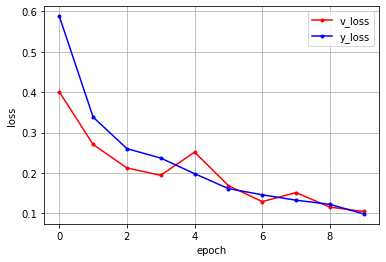

In [ ]:
# 학습
with tf.device('/device:GPU:0'):
  hist = model.fit( train_X, train_Y, epochs=10, 
                 validation_data=(valid_X, valid_Y), batch_size=32)

showLoss( hist )